# SVM(Support Vector Machine)
https://en.wikipedia.org/wiki/Support-vector_machine

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
#import scikitplot as skplt
from joblib import dump, load

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30); y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], 
               alpha=0.5, linestyles=['--', '-', '--'])
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                 s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim); ax.set_ylim(ylim)

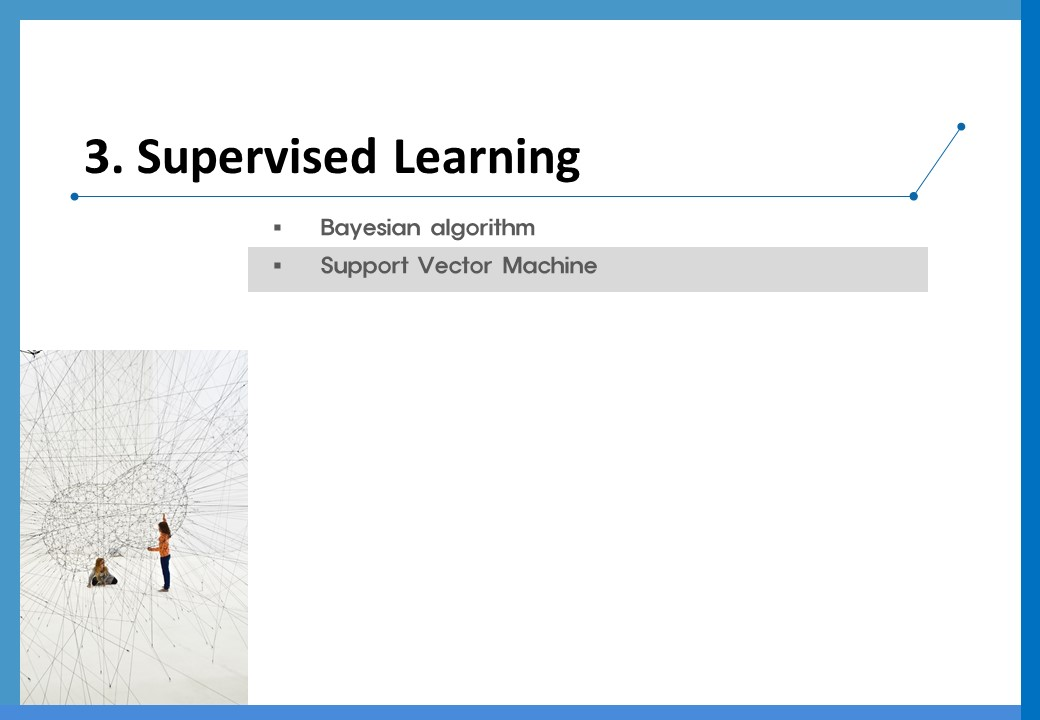

In [1]:
dir_path = r'D:\ASSIST\img\aSSIST_20220111_1학기_조상구'
from IPython.display import Image
width=800; height=500
Image(filename=dir_path +'/슬라이드133.jpg', width=width, height=height)

## Understanding SVM 

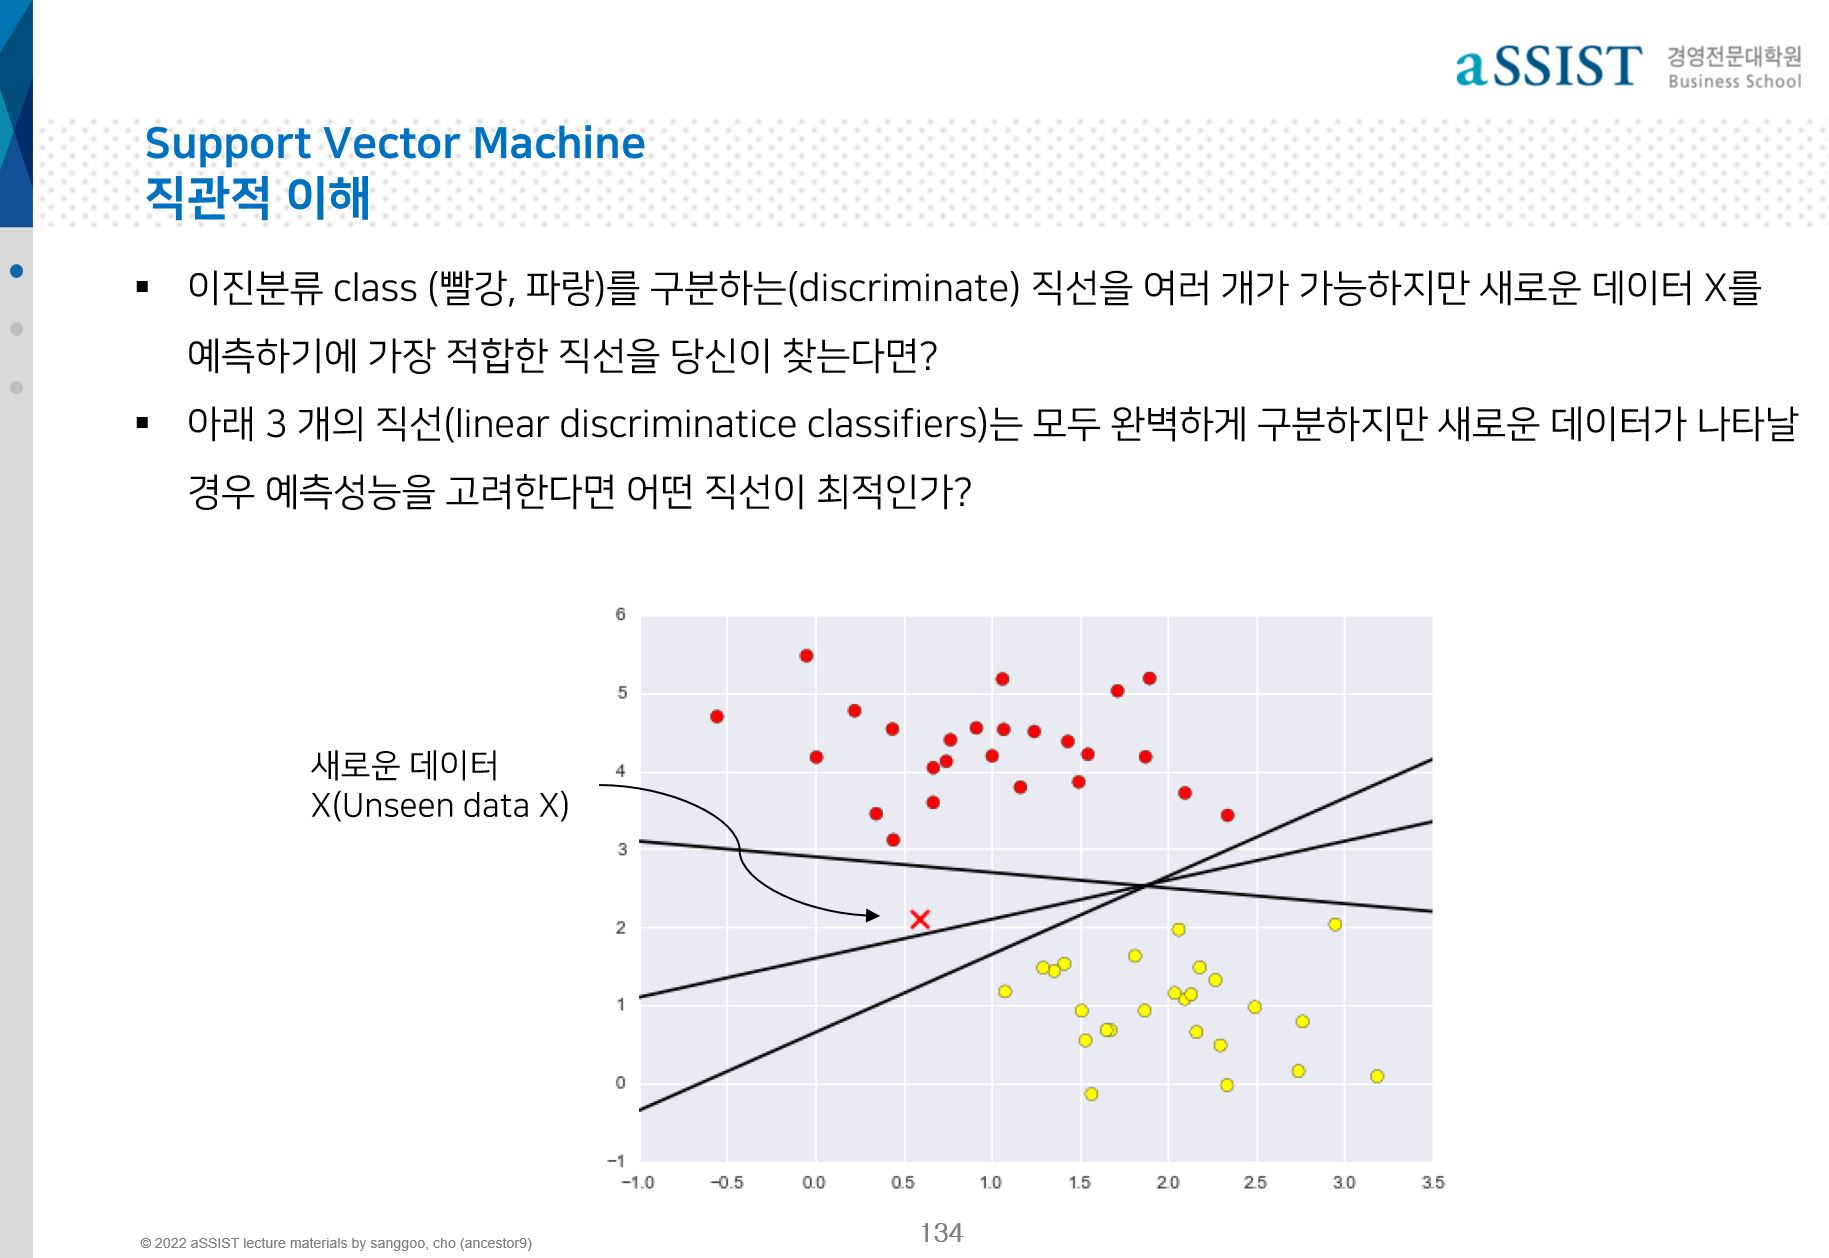

In [ ]:
Image(filename=dir_path +'/슬라이드134.jpg', width=width, height=height)

### Unseeen data에 대한 예측 성능을 높이기 위해 일반화된 모델은 직선(초평면)과 가장 거리가 먼 wx+b =0 직선이다.
### Finding w, b is to optimize SVM algorithm.

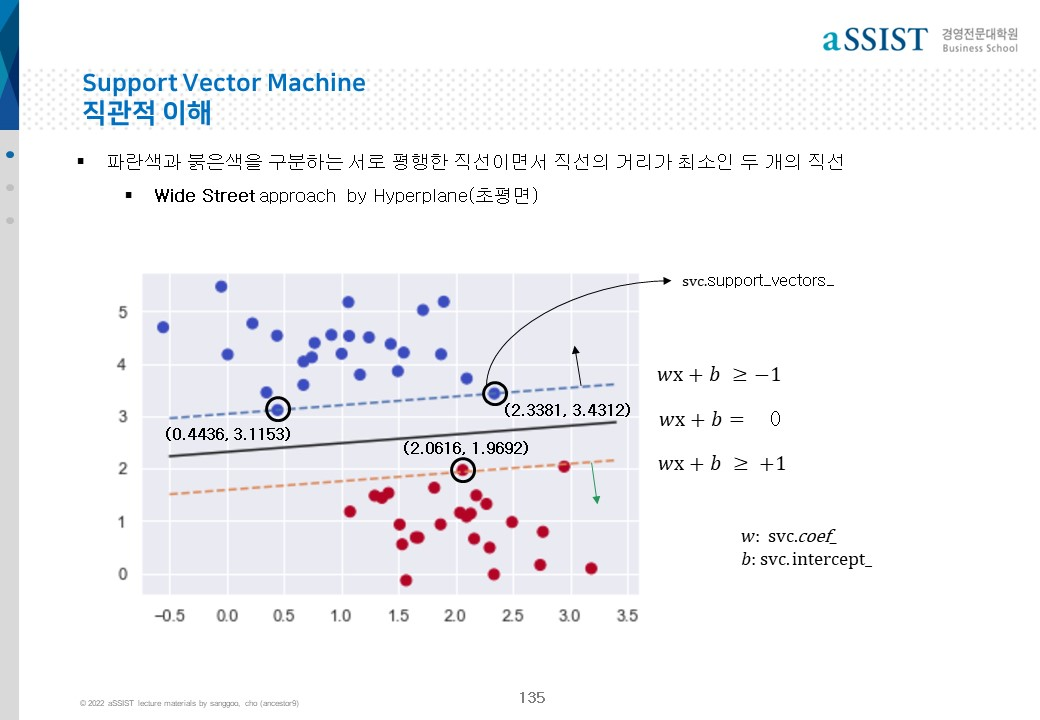

In [ ]:
Image(filename=dir_path +'/슬라이드135.jpg', width=width, height=height)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


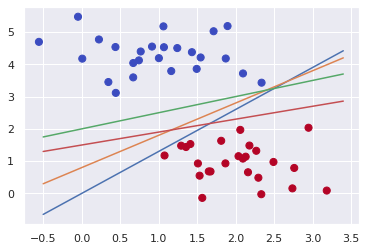

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm');
X_fit = np.arange(-0.5, 3.5, 0.1)
plt.plot(X_fit, X_fit*1.3); plt.plot(X_fit, 0.8+X_fit*1);
plt.plot(X_fit, 2+X_fit*0.5);plt.plot(X_fit, 1.5+X_fit*0.4)

In [ ]:
from sklearn.svm import SVC 
svc = SVC(kernel='linear', random_state=11)
svc.fit(X, y)
svc.support_vectors_  # [(X[:, 0][i].round(4), X[:, 1][i].round(4)) for i in svc.support_]
svc.coef_
svc.intercept_ + svc.support_vectors_@svc.coef_.reshape(2,1)

SVC(kernel='linear', random_state=11)

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

array([[ 0.22967329, -1.37758262]])

array([[-0.99999987],
       [-0.9999994 ],
       [ 0.95048419]])

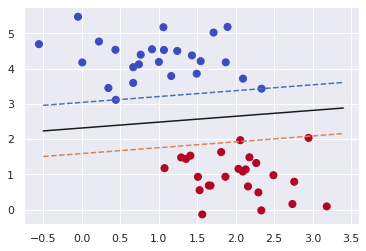

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
center_fence= (-svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
upper_fence= (-1- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
lower_fence= (1- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
plt.plot(X_fit,upper_fence,linestyle='dashed'); plt.plot(X_fit, center_fence, 'k'); 
plt.plot(X_fit,lower_fence,linestyle='dashed')

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

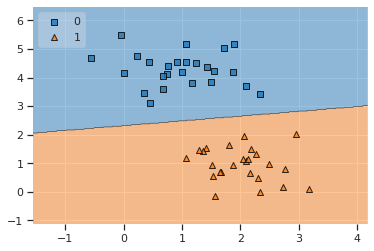

In [ ]:
from mlxtend.plotting import plot_decision_regions # 2차원 특성변수의 분류경계선을 시각
fig= plot_decision_regions(X, y, clf=svc, legend=2)

## SVM 알고리즘

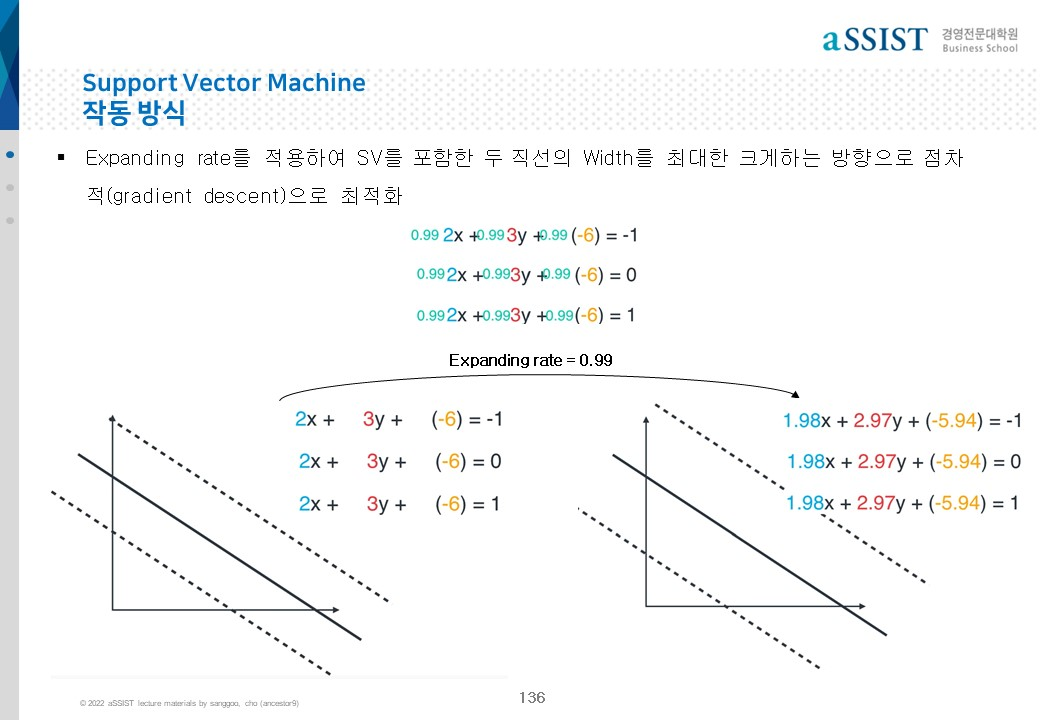

In [ ]:
Image(filename=dir_path +'/슬라이드136.jpg', width=width, height=height)

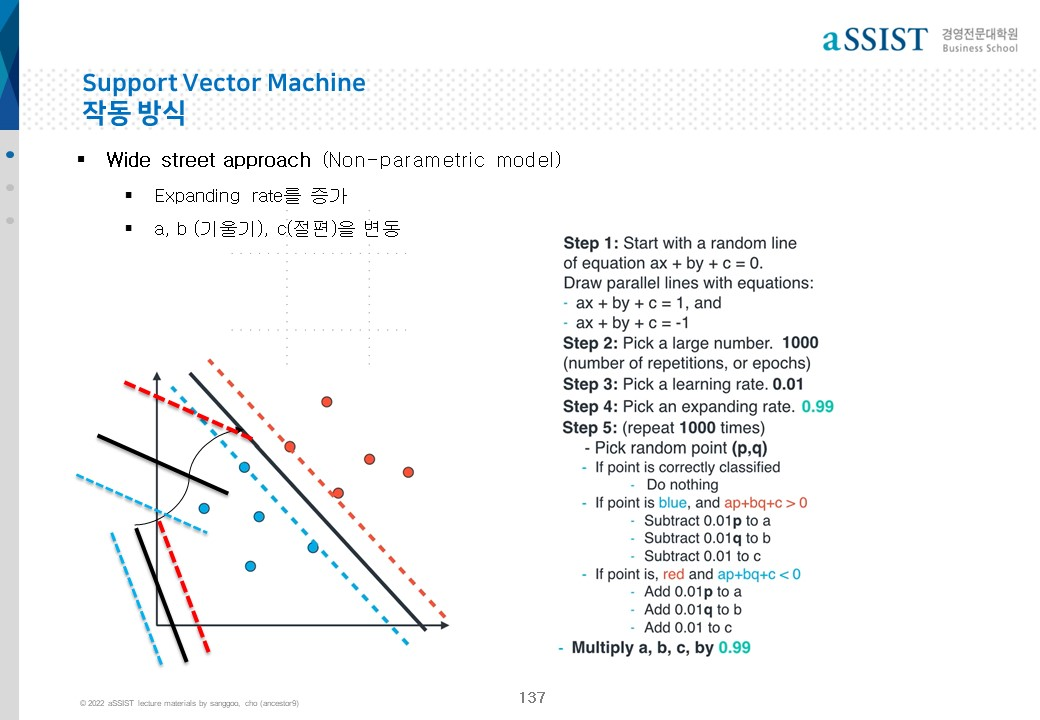

In [ ]:
Image(filename=dir_path +'/슬라이드137.jpg', width=width, height=height)

### 2차원 평면에서 그래픽으로 설명

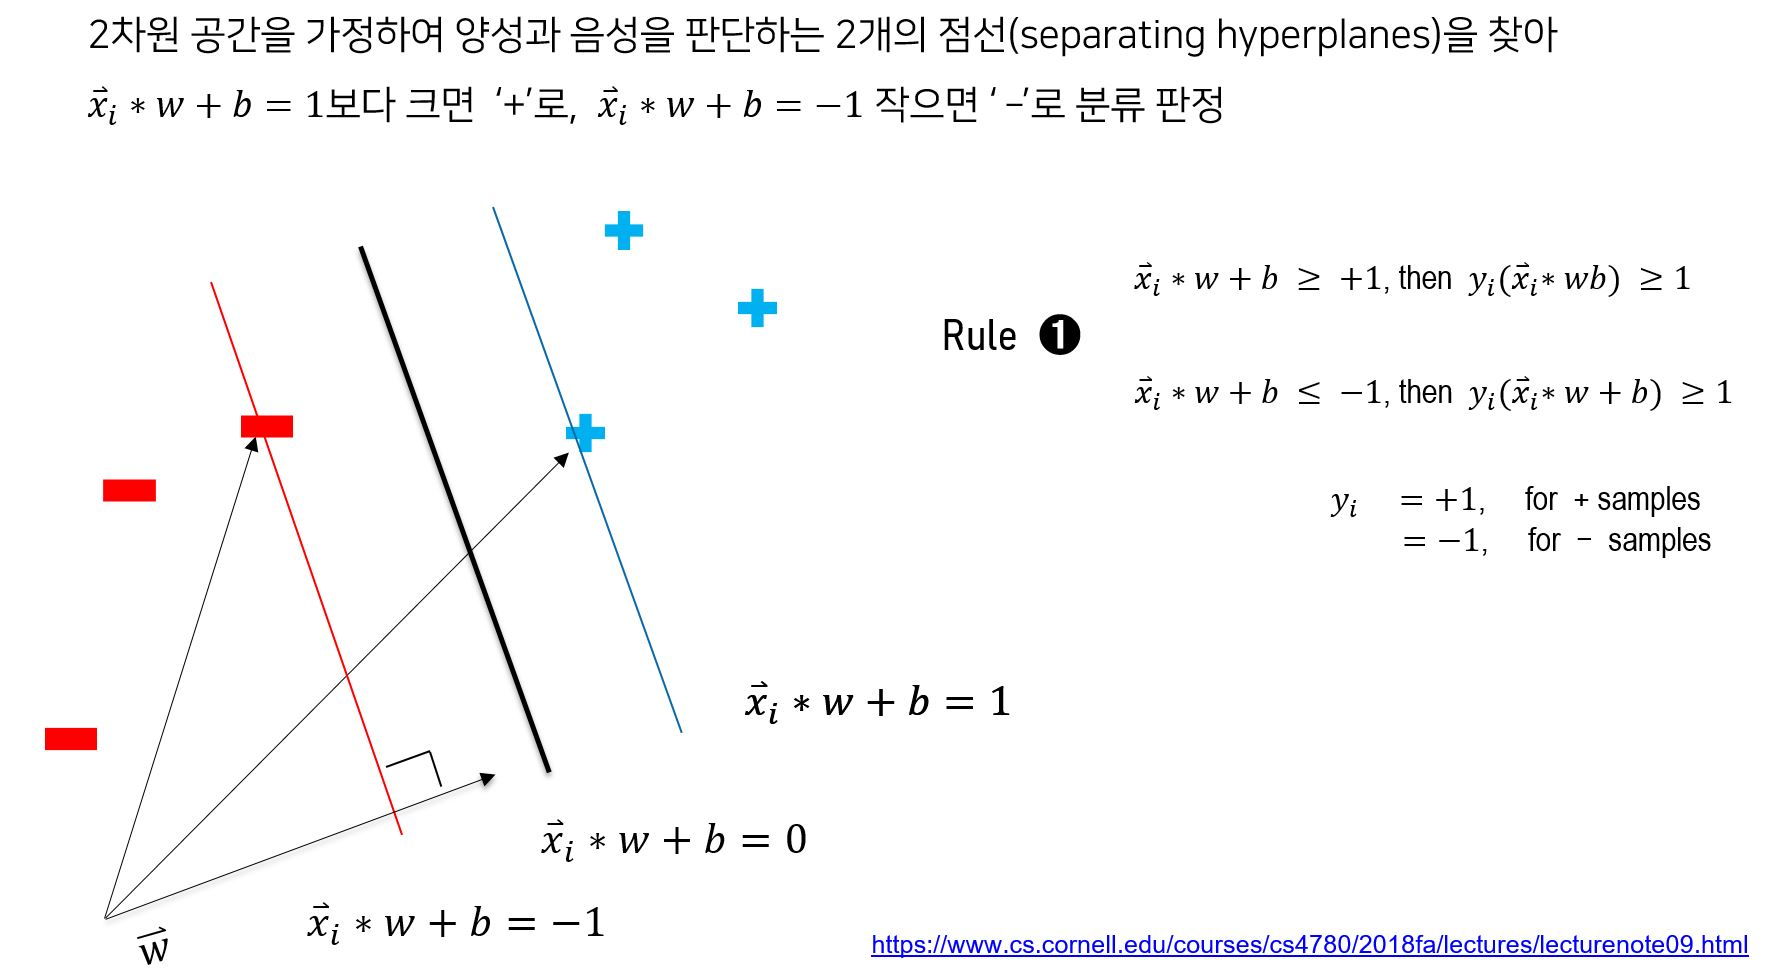

In [3]:
Image(filename=dir_path +'/svc01.jpg', width=width, height=height)

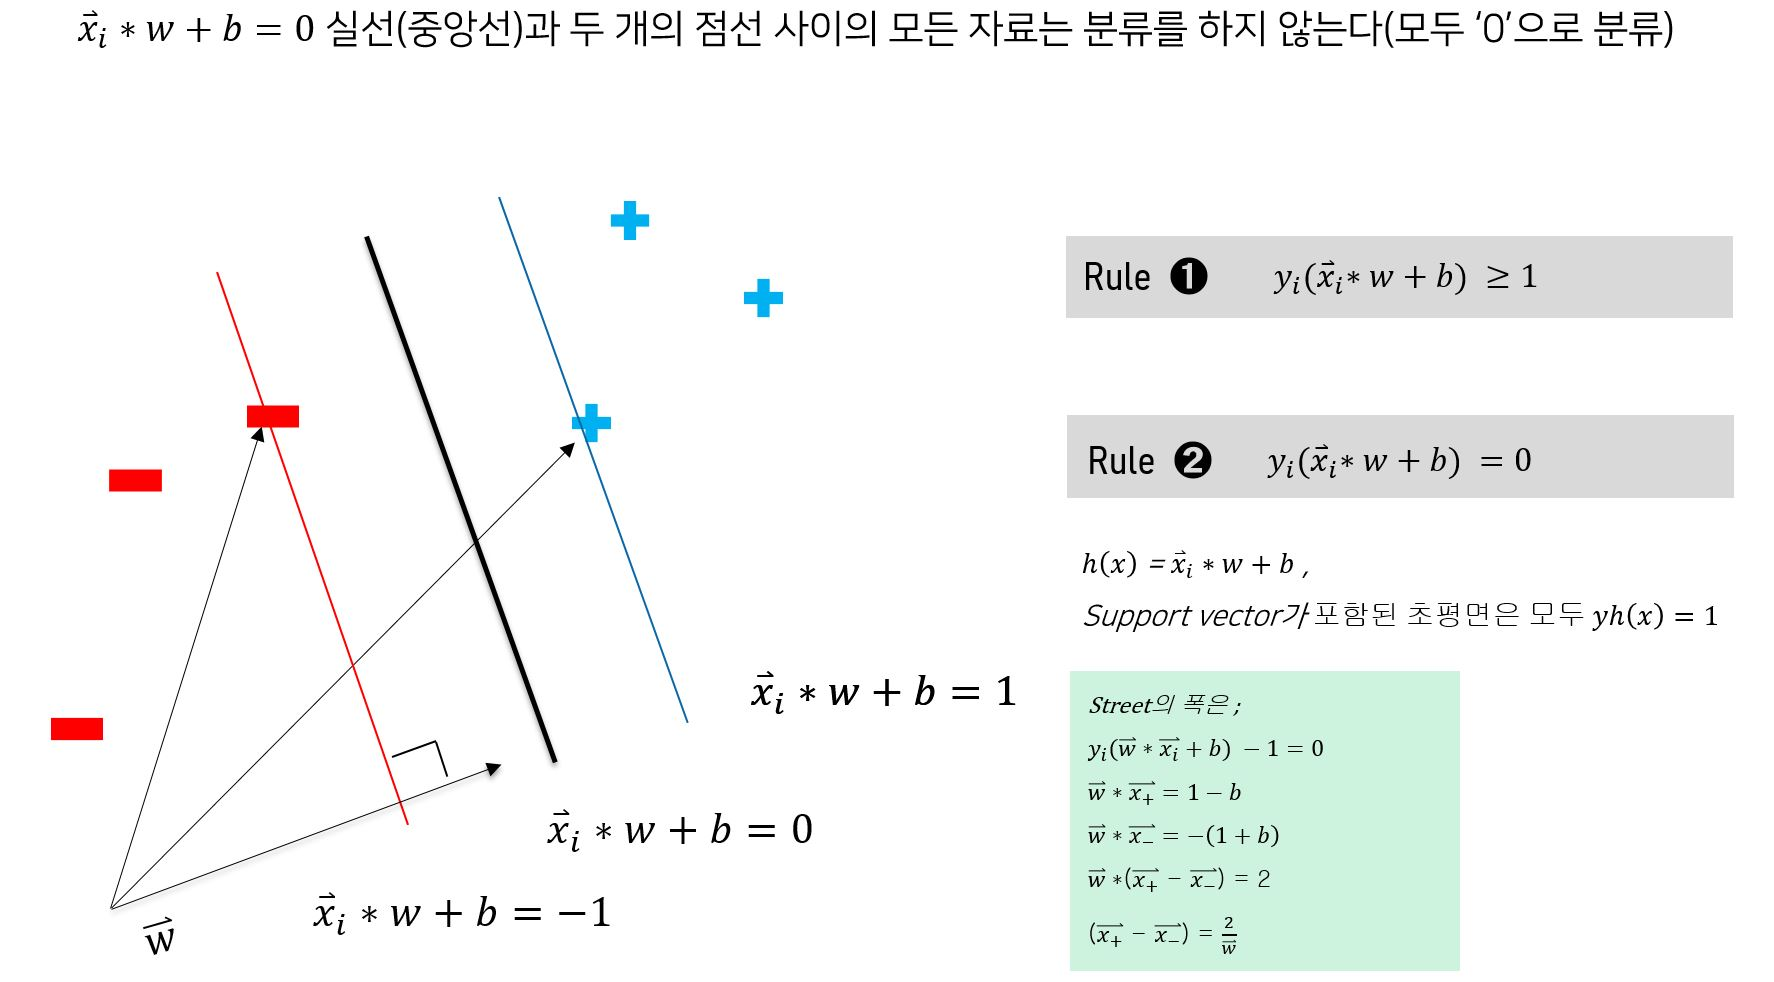

In [5]:
Image(filename=dir_path +'/svc02.jpg', width=width, height=height)

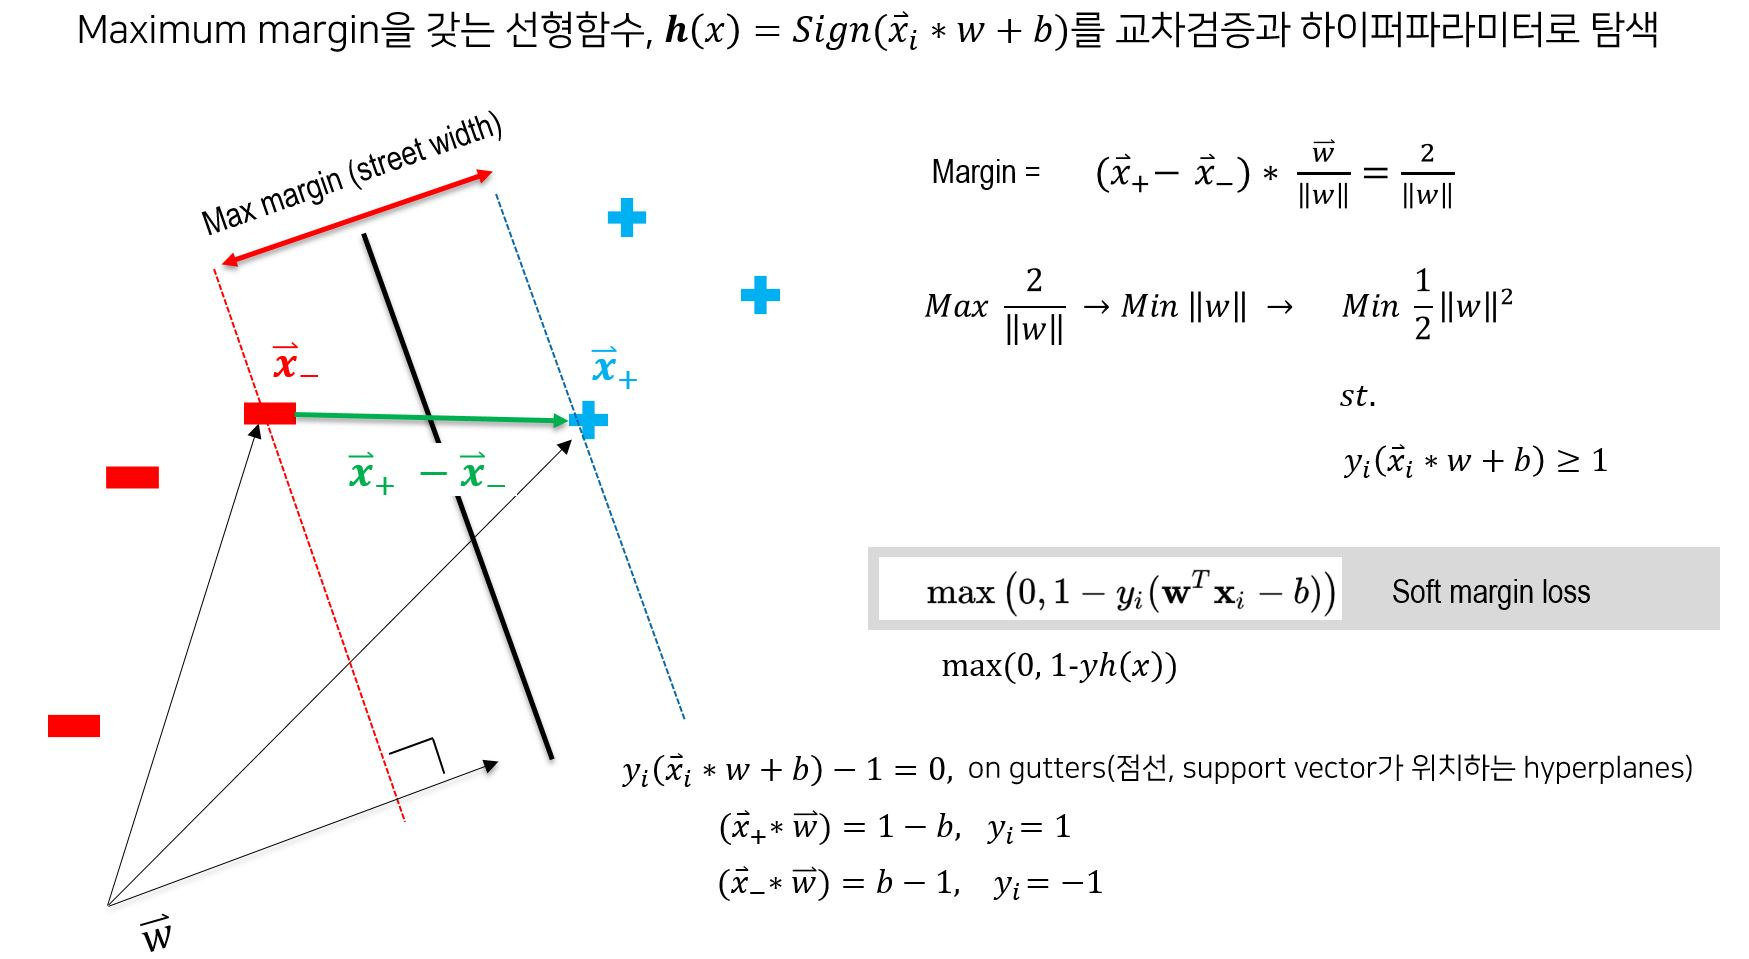

In [6]:
Image(filename=dir_path +'/svc03.jpg', width=width, height=height)

### Minimize ||W||
### subject to 

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c2f2091faefb56179a2d4720935f5a69a20b246d'>

## SVM 알고리즘의 독창성
- 일반적인 알고리즘은 (1)번 알고리즘을 (2)번으로 이동시키면서 error rate를 zero로 만들지만 SVM은 모든 class에 대해 가장 멀리 위치하게 최적화

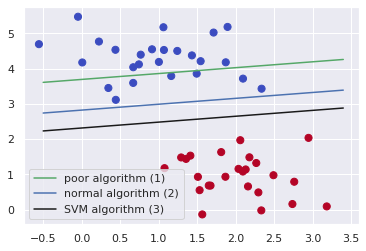

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
poor_al = (-1.9- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
algorithm = (-0.7- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
hyperplane = (-svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
plt.plot(X_fit, poor_al,'g', label = 'poor algorithm (1)'); 
plt.plot(X_fit, algorithm,'b', label = 'normal algorithm (2)'); 
plt.plot(X_fit, hyperplane, 'k', label = 'SVM algorithm (3)');
plt.legend()

In [ ]:
upper_fence

array([2.95799092, 2.97466311, 2.99133531, 3.00800751, 3.02467971,
       3.0413519 , 3.0580241 , 3.0746963 , 3.0913685 , 3.10804069,
       3.12471289, 3.14138509, 3.15805729, 3.17472948, 3.19140168,
       3.20807388, 3.22474607, 3.24141827, 3.25809047, 3.27476267,
       3.29143486, 3.30810706, 3.32477926, 3.34145146, 3.35812365,
       3.37479585, 3.39146805, 3.40814025, 3.42481244, 3.44148464,
       3.45815684, 3.47482903, 3.49150123, 3.50817343, 3.52484563,
       3.54151782, 3.55819002, 3.57486222, 3.59153442, 3.60820661])

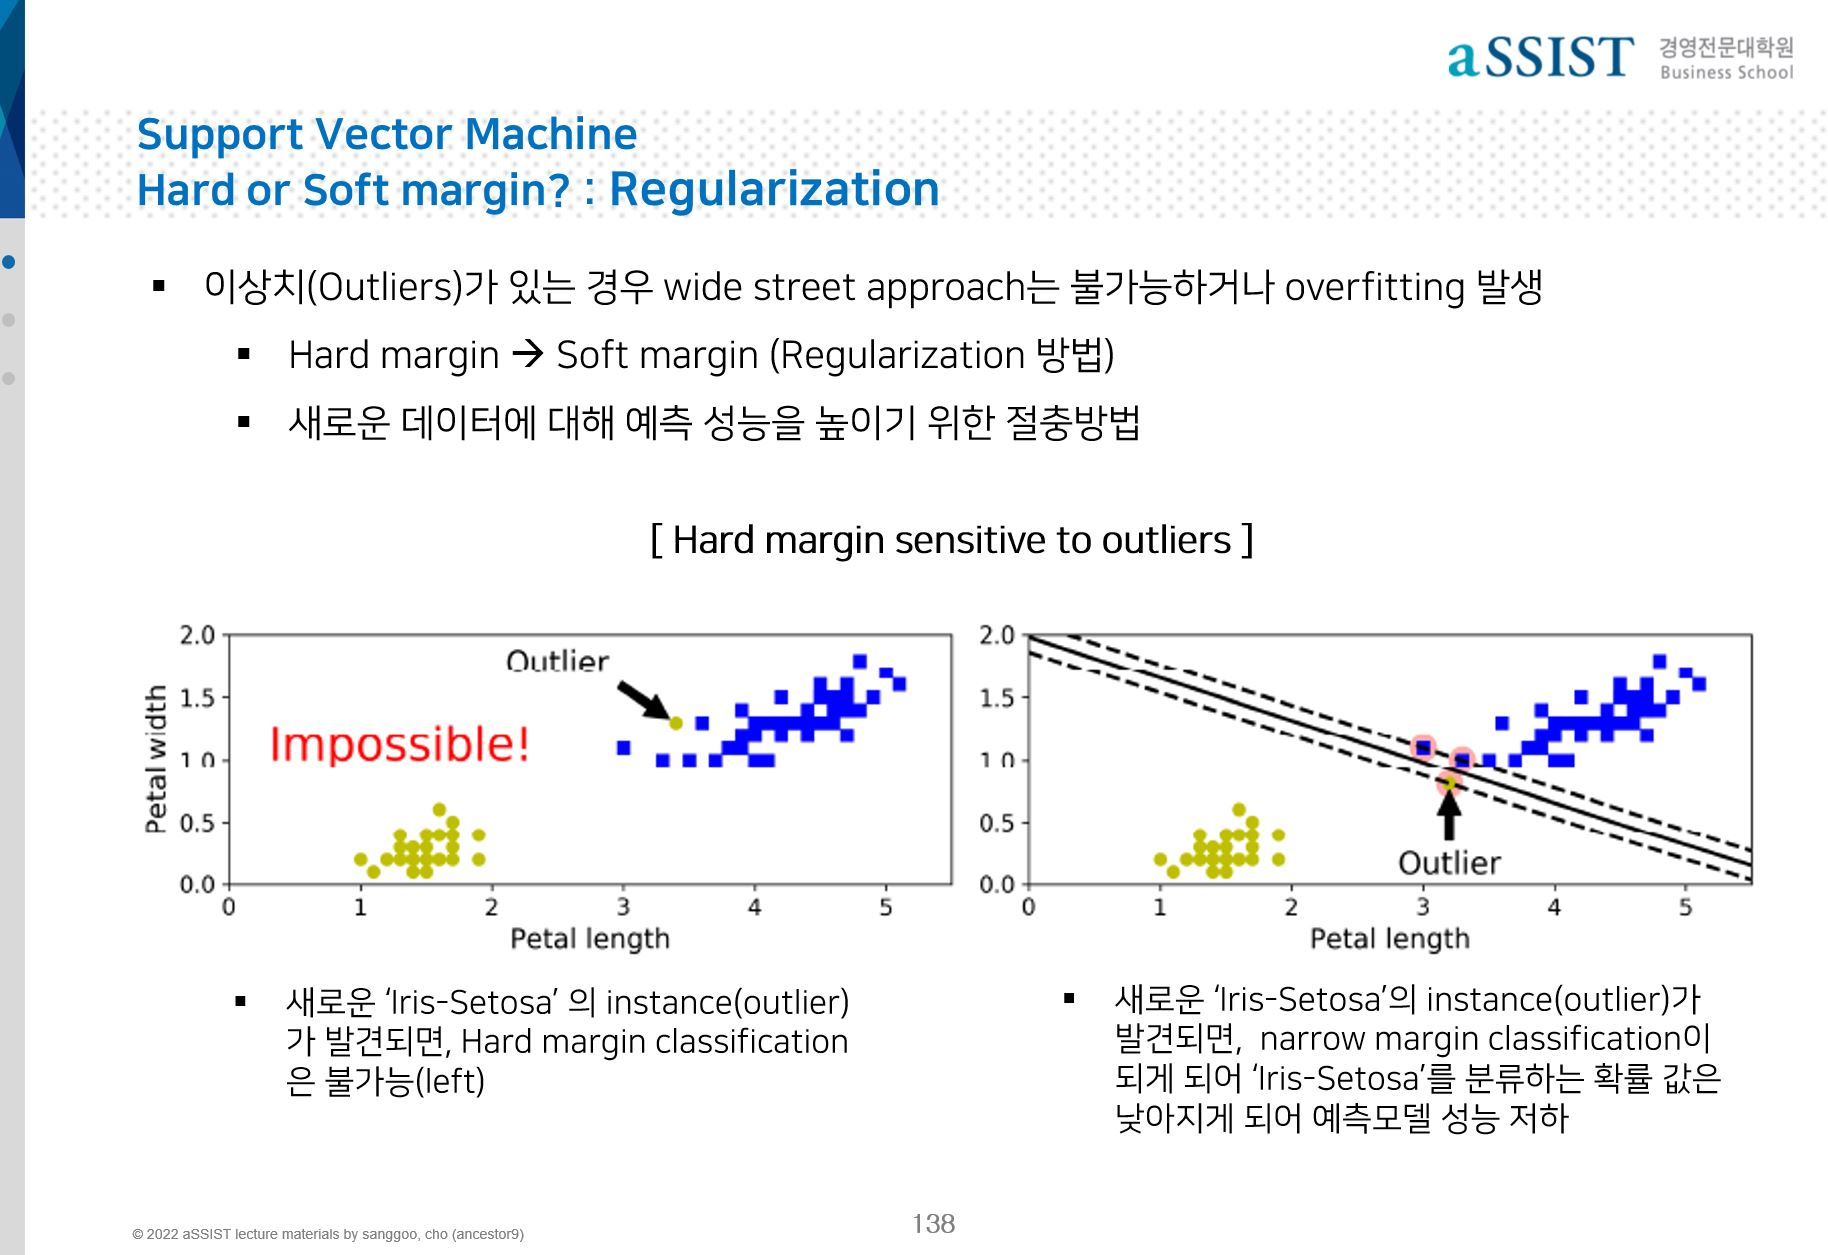

In [ ]:
Image(filename=dir_path +'/슬라이드138.jpg', width=width, height=height)

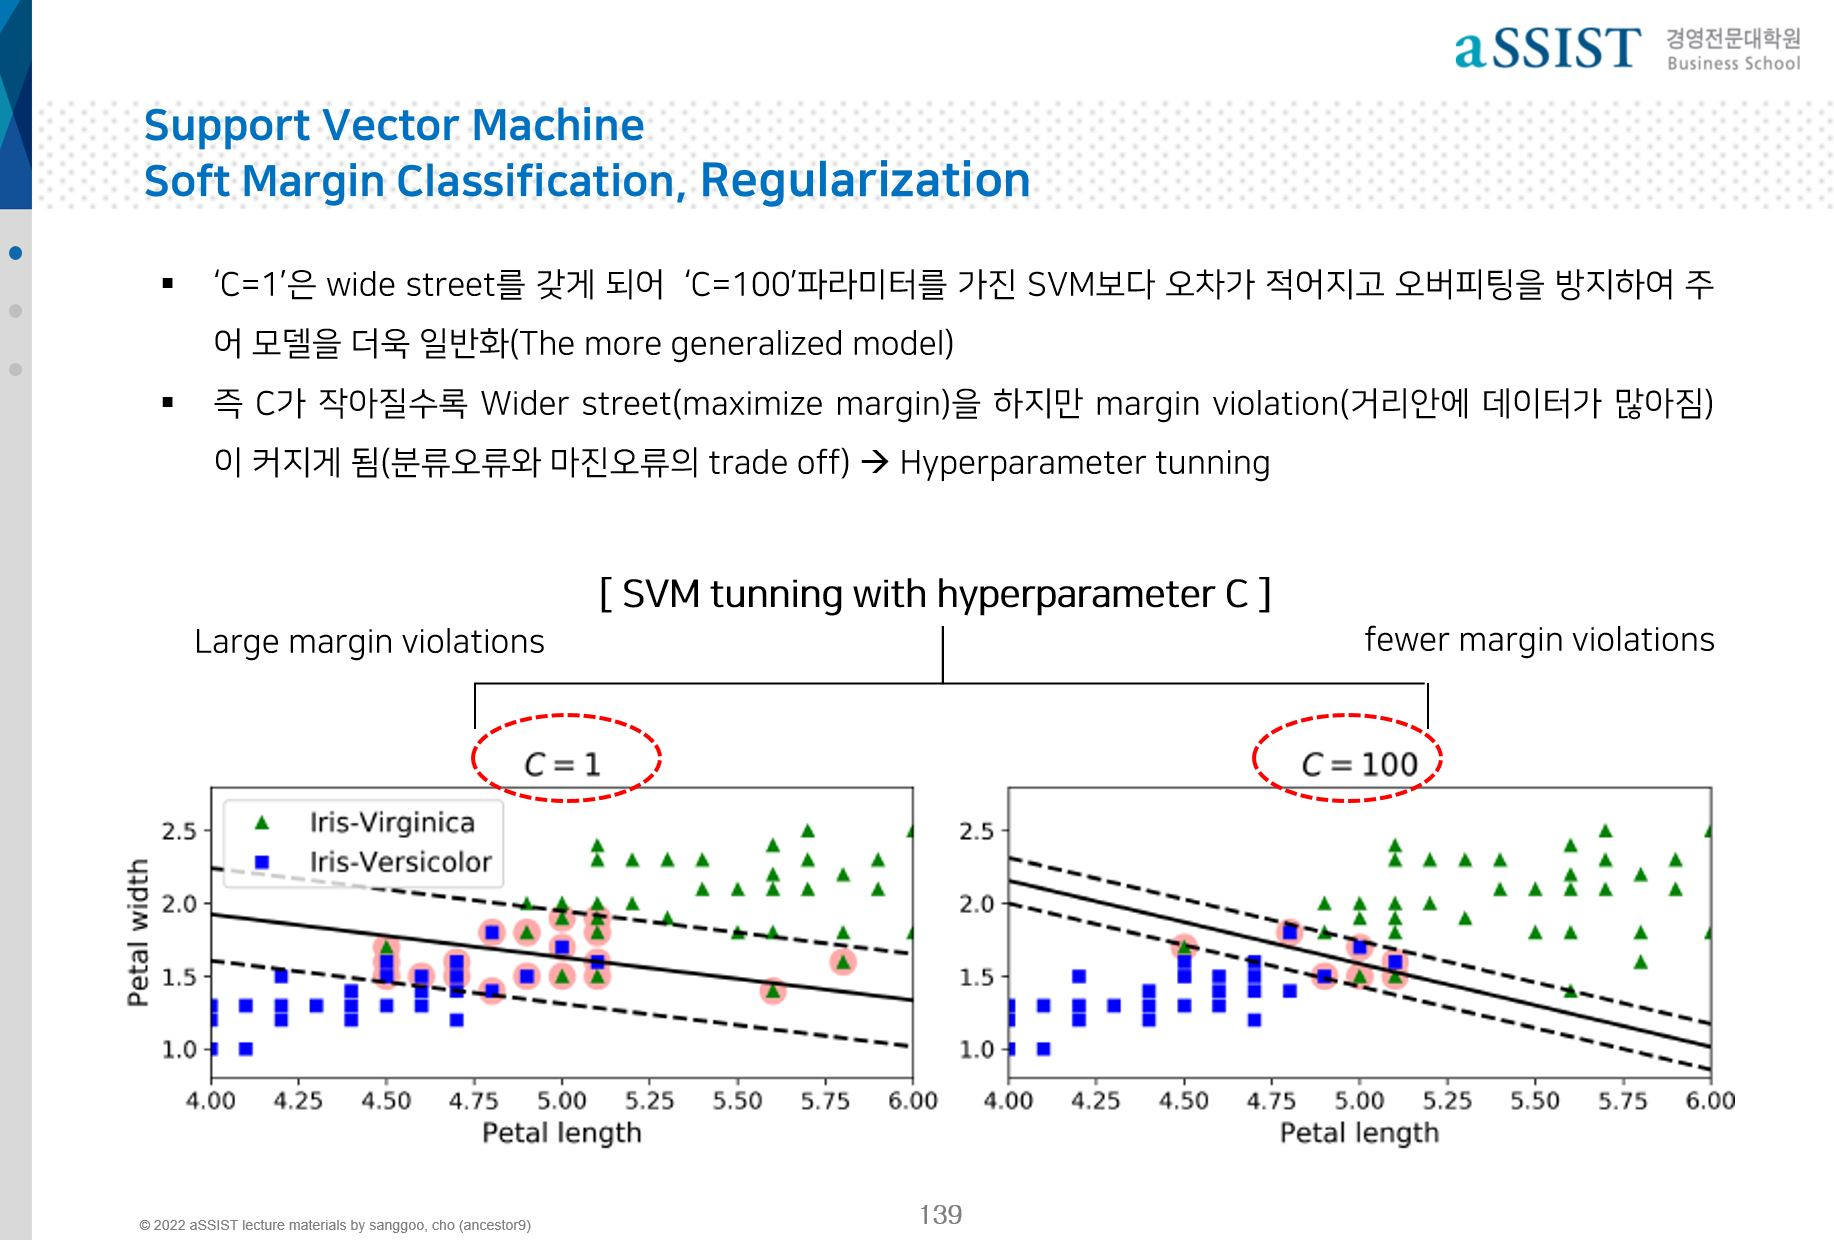

In [ ]:
Image(filename=dir_path +'/슬라이드139.jpg', width=width, height=height)

## Hard or Soft margin
- 일반화 모델(Generalized Model)기준에서는 오분류를 어느정도 인정하면서 Wide street (hyperparamet C가 적은 SVM)를 선택하는 것이 바람직함
<img src='https://hleecaster.com/wp-content/uploads/2020/01/svm06.png' width=600 height=300>

### Softmargin (C hyperparameter)
- C가 클수록 개별 인스턴스 class에 신경을 쓰면서(오류를 최소화) SVM을 찾게 되면 과적합(Overfitting)
- C가 작을수록 개별 인스턴스 class에 신경을 덜 쓰면서(오류를 어느 정도 인정) SVM을 찾게 되면 과적합(Underfitting)

- C를 hyperparamet tunning하면서 SVM을 찾는다.

     |████████████████████████████████| 540 kB 15.8 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=773e51e13628b2901b2954d57e794ac174886ba0c6bf919c1c78d5fbbc5fdbe0
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


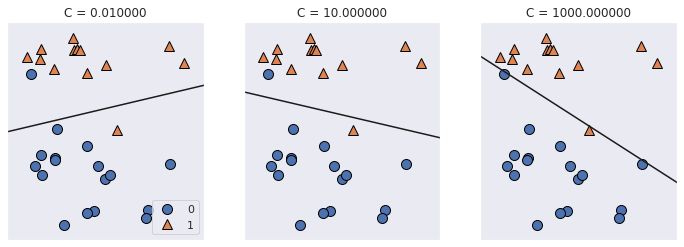

In [ ]:
! pip install mglearn
import mglearn
mglearn.plots.plot_linear_svc_regularization()

<img src='https://i.stack.imgur.com/obcn9.png'>

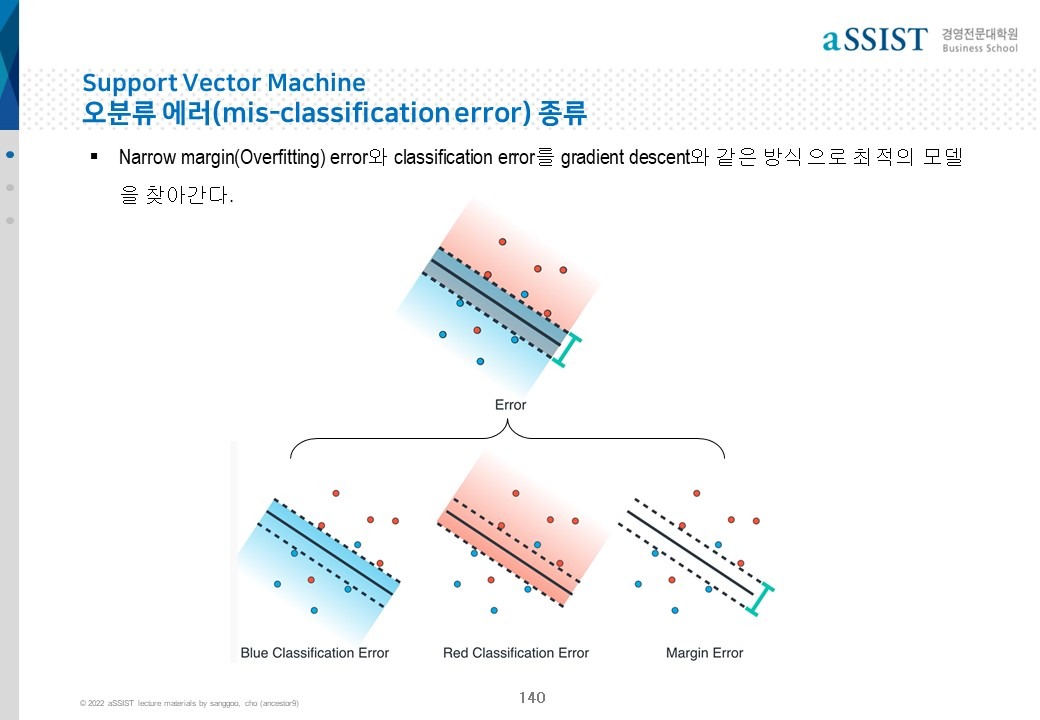

In [ ]:
Image(filename=dir_path +'/슬라이드140.jpg', width=width, height=height)

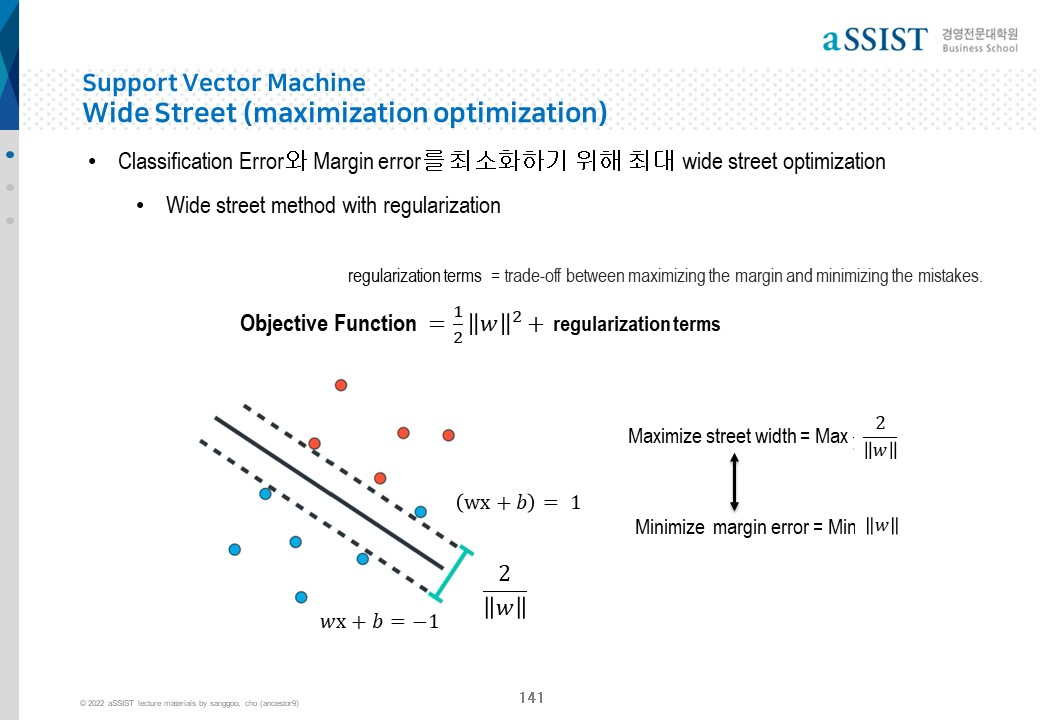

In [ ]:
Image(filename=dir_path +'/슬라이드141.jpg', width=width, height=height)

<img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/3fbc23e60483b1d9b0ea2b9fc378db02e33e4c50'>

# What is kernel and kernel trick?

<img src='http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/topology_1D-2D_train.gif'>

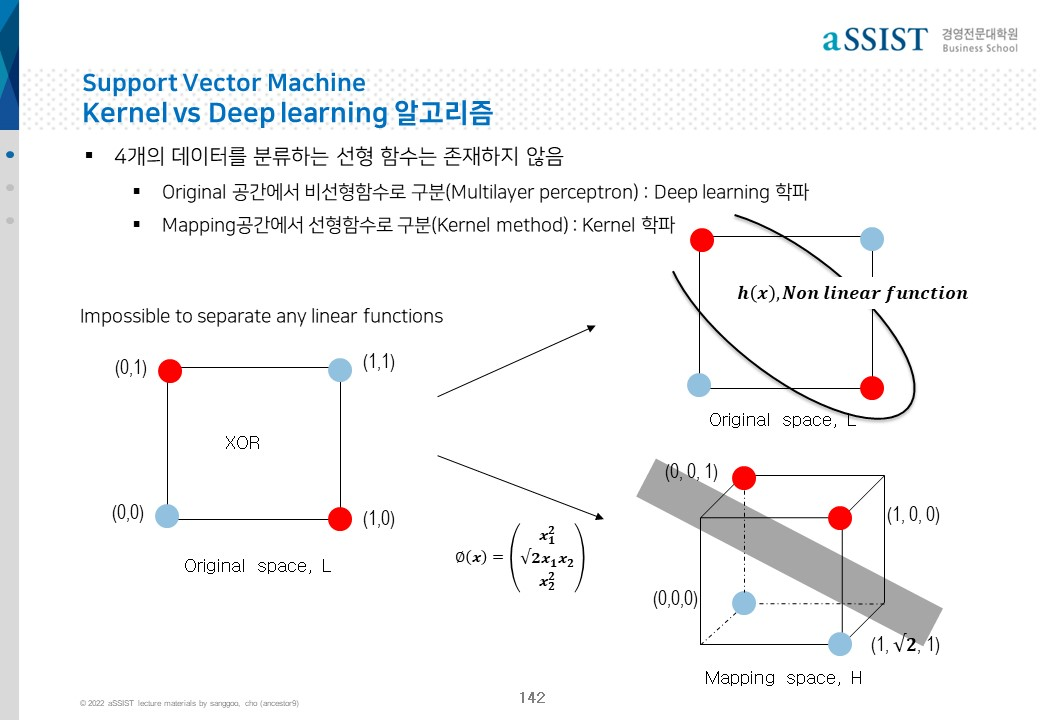

In [ ]:
Image(filename=dir_path +'/슬라이드142.jpg', width=width, height=height)

Text(0.5, 0, 'x1')

Text(0, 0.5, 'x2')

Text(0.5, 1.0, 'Problem')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


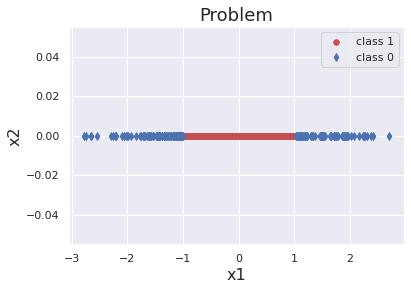

Text(0.5, 0, '$\\phi_1$')

Text(0, 0.5, '$\\phi_2$')

Text(0.5, 1.0, 'Problem solving in Transformed higer Space')

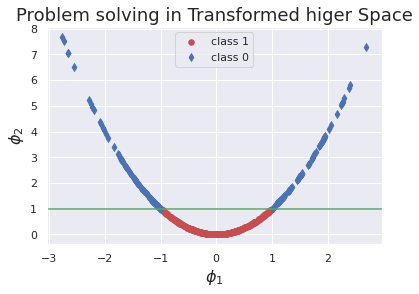

In [ ]:
np.random.seed(0)
X = np.random.randn(500); tr = 1
X_pos = X[np.logical_and(X<tr, X>-tr)]; X_neg = X[np.logical_or(X>=tr, X<=-tr)]
plt.scatter(X_pos, y=X_pos*0, c='r', marker='o', label='class 1', s=30)
plt.scatter(X_neg, y=X_neg*0, c='b', marker='d', label='class 0', s=30)
plt.legend(); plt.xlabel('x1', fontsize='16'); plt.ylabel('x2', fontsize='16'); 
plt.title('Problem', fontsize='18');plt.show()

plt.scatter(X_pos, y=X_pos**2, c='r', marker='o', label='class 1', s=30)
plt.scatter(X_neg, y=X_neg**2, c='b', marker='d', label='class 0', s=30)
plt.legend(); plt.xlabel(r'$\phi_1$',fontsize='16'); plt.ylabel(r'$\phi_2$',fontsize='16')
plt.title('Problem solving in Transformed higer Space', fontsize='18')
plt.axhline(y= tr, color='g', linestyle='-')

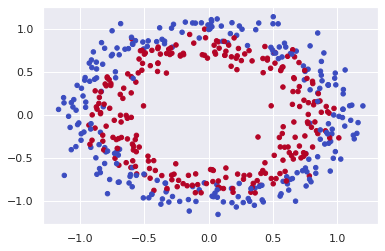

<Figure size 576x576 with 0 Axes>

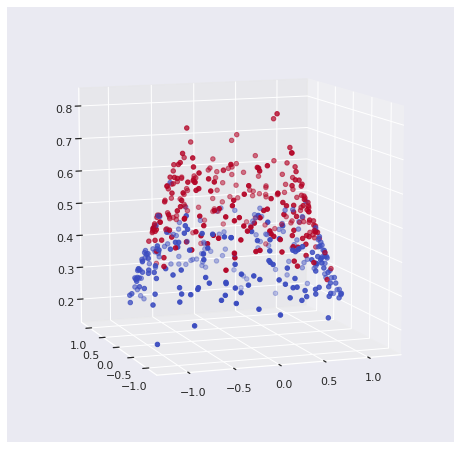

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, random_state=11, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm');plt.show()

from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, cmap='coolwarm')
ax.view_init(10, 250)

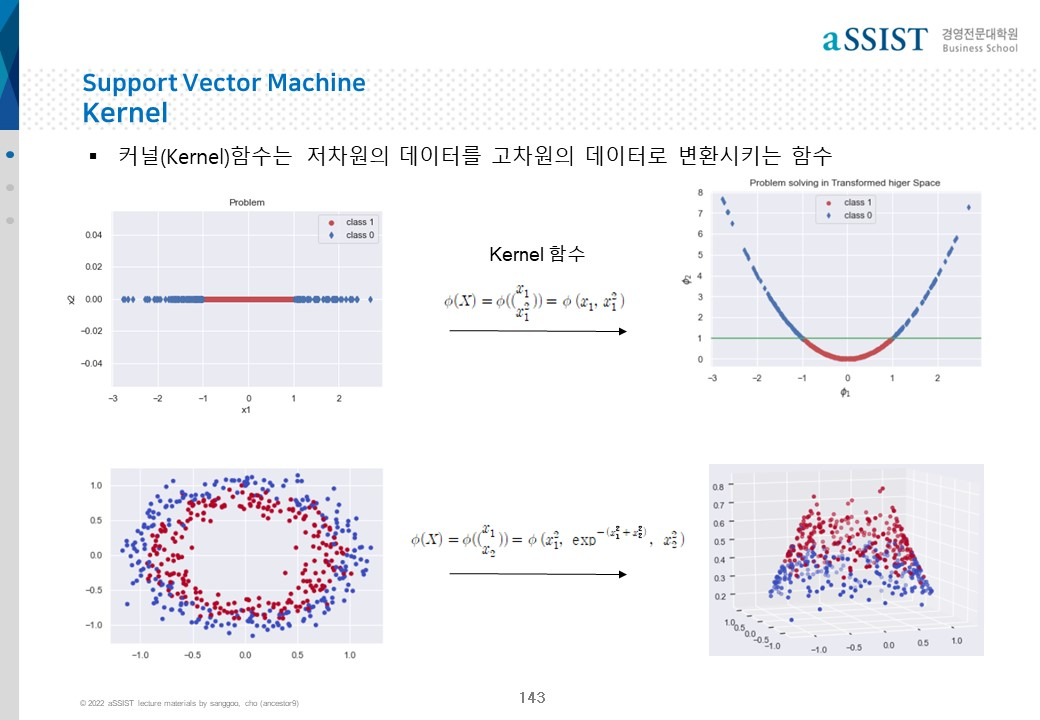

In [ ]:
Image(filename=dir_path +'/슬라이드143.jpg', width=width, height=height)

# Kernel density estimation
https://en.wikipedia.org/wiki/Positive-definite_kernel

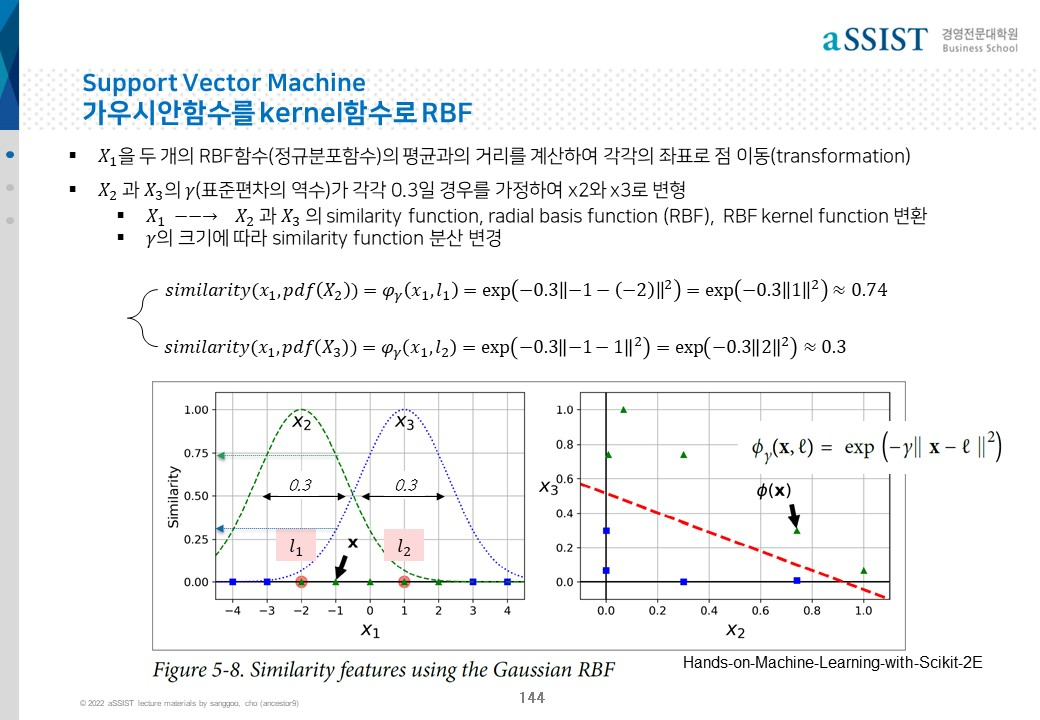

In [ ]:
Image(filename=dir_path +'/슬라이드144.jpg', width=width, height=height)

### 1. 자료를 Gaussian RBF(Kernel)을 사용하여 pdf로 변환 
- Nonlinear SVM classification (Hands-on Macjine learning, O'RRELY Book
#### x1  = 수열 자료(-5 ~ +5)
#### x2, x3 = x1자료에 해당되는 정규분포를 pdf 자료2, 3 생성자료

Text(0, 0.5, 'Similarity')

Text(0.5, 0, 'x1')

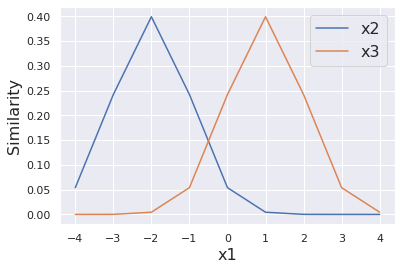

In [ ]:
import scipy.stats as stats
x1 = np.arange(-4, 5, 1)
x2 = stats.norm.pdf(x1, -2, 1); x3 = stats.norm.pdf(x1, 1, 1)
data = pd.DataFrame(np.c_[x1, x2, x3], columns = ['x1', 'x2', 'x3'])
data.set_index('x1', inplace=True); data[['x2', 'x3']].plot()
plt.ylabel('Similarity', fontsize = 16); plt.xlabel("x1", fontsize = 16)
plt.legend(fontsize = 16)

Text(0, 0.5, 'x3')

Text(0.5, 0, 'x2')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


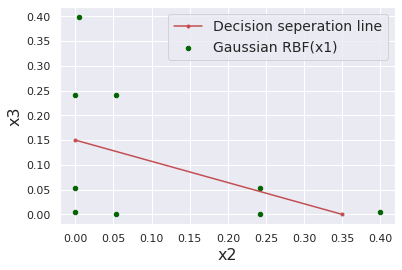

In [ ]:
ax1 = data.plot.scatter(x='x2', y='x3', c='DarkGreen', label='Gaussian RBF(x1)')
plt.plot([0,0.35], [0.15,0.00], 'r.-', label='Decision seperation line')
plt.legend(fontsize = 14); plt.ylabel('x3', fontsize = 16); plt.xlabel("x2", fontsize = 16)

### Similarity (Likelihood)
- TN와 TP의 영역에 있는 x1의 RBF변환값은 x2, x3가 둘중 하나는 '0'에 가까움
- FN와 FP의 영역에 있는 x1의 RBF변환값은 x2, x3가 모두 '0' 보다 상당히 크다
- if x1= -1,   x2=0.25, x3=0.05로 좌표 이동, 즉 x1=-1은 x2와 가깝다(similarity가 높다) 

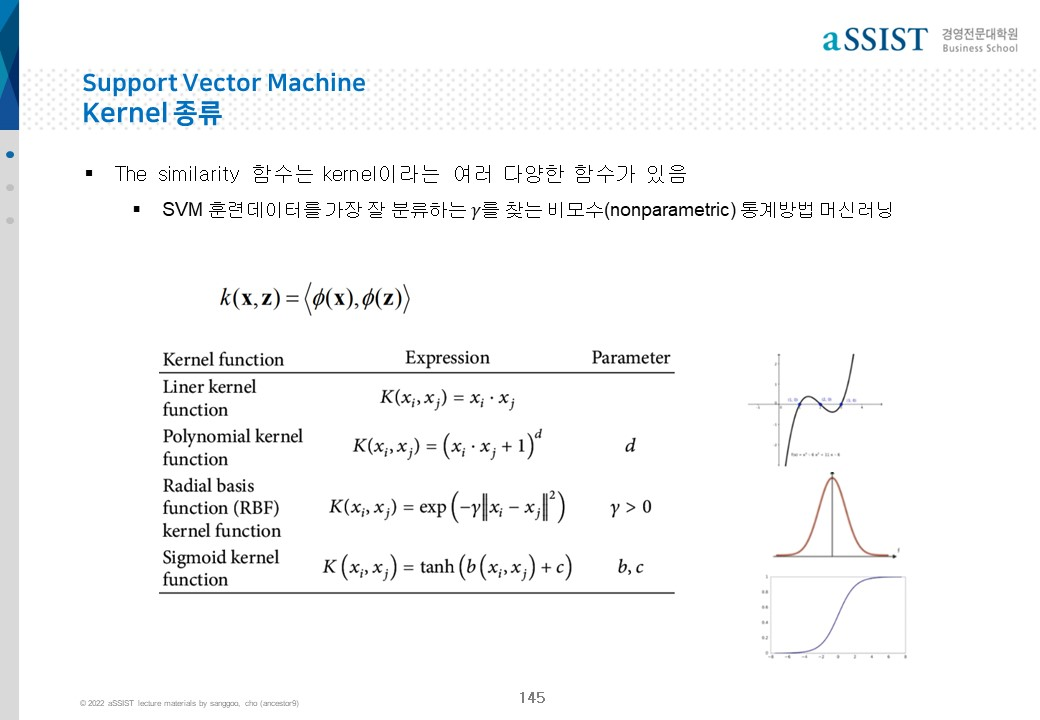

In [ ]:
Image(filename=dir_path +'/슬라이드145.jpg', width=width, height=height)

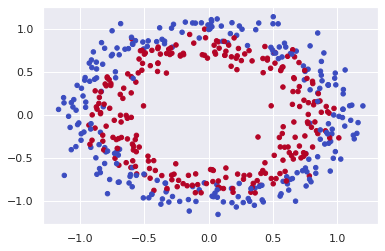

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, random_state=11, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

Text(0.5, 1.0, "SVC(kernel='linear')")

Text(0.5, 1.0, 'SVC()')

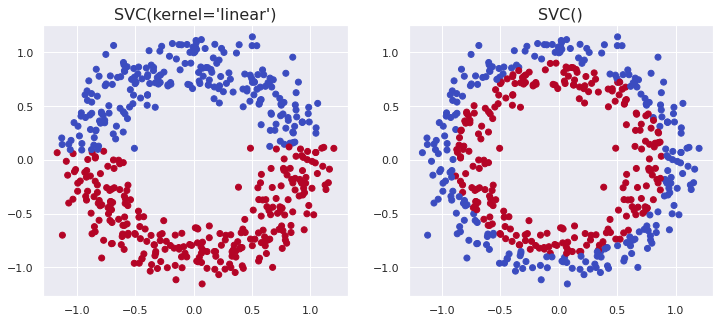

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
classifiers = [SVC(kernel='linear'), SVC(kernel='rbf')]
for i, classifier in enumerate(classifiers) :
    axs[i].set_title(classifier, fontsize='16')
    y_pred = classifier.fit(X, y).predict(X) 
    axs[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')

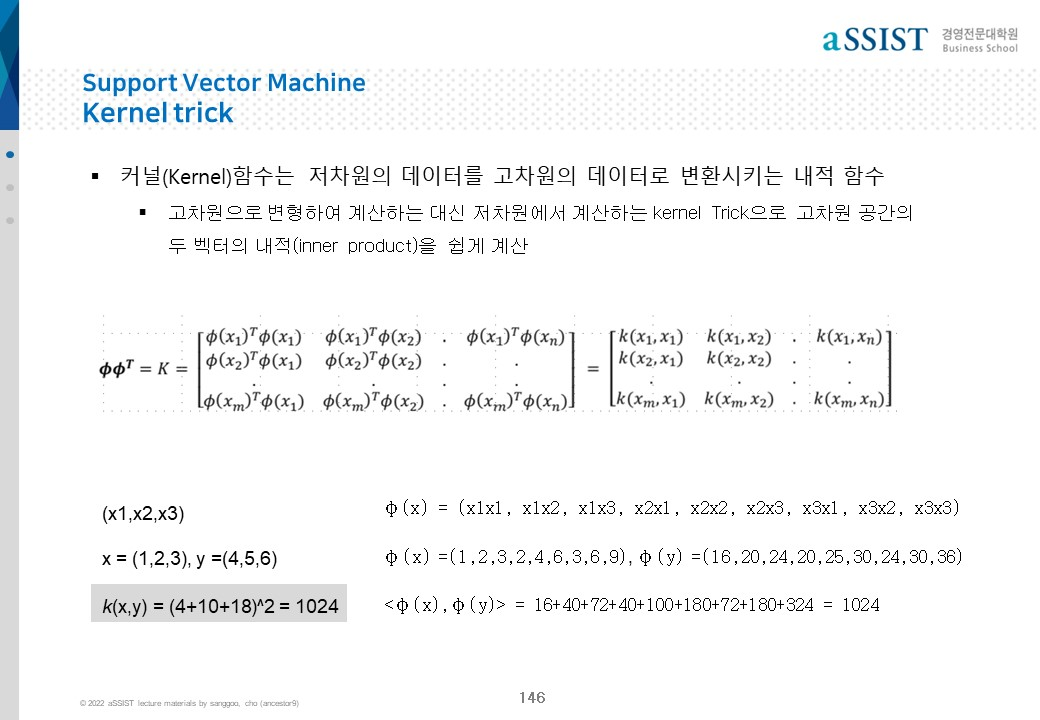

In [ ]:
# Kernel trick
Image(filename=dir_path +'/슬라이드146.jpg', width=width, height=height)

In [ ]:
x = np.array([1,2,3]); y = np.array([4,5,6])
x_t = x.reshape(-1,1); x = x.reshape(1,-1)
q_x = x_t@x
q_x

y_t = y.reshape(-1,1); y = y.reshape(1,-1)
q_y = y_t@y
q_y

q_x * q_y
(q_x * q_y).sum()

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

array([[16, 20, 24],
       [20, 25, 30],
       [24, 30, 36]])

array([[ 16,  40,  72],
       [ 40, 100, 180],
       [ 72, 180, 324]])

1024

In [ ]:
x = np.array([1,2,3]); y = np.array([4,5,6])
np.dot(x,y)**2 , # kernel function, sum((x*y))**2 

(1024,)

# SVM with hyperparameter

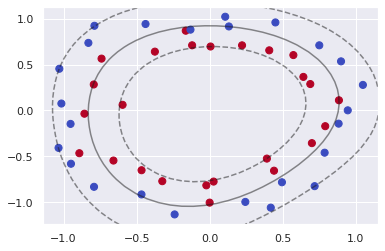

In [ ]:
X, y = make_circles(n_samples=50, random_state=11, noise=0.1)
model = SVC(kernel='rbf')
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

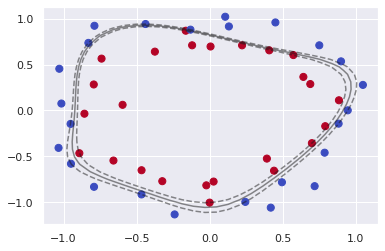

In [ ]:
model = SVC(kernel='rbf', C=1E10)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

In [ ]:
model.predict_proba(X)

AttributeError: ignored

In [ ]:
model.decision_function(X)

array([ 19.44321087,   5.37466278,   8.29027506,  -8.52733493,
        -1.46266158,   1.00028663,   8.24420066,   3.59936256,
        -0.99956068,  -0.99962784,  -2.46634641,   4.88641832,
       -12.84706896,   8.89783492,   2.6740324 ,  -6.14980969,
         0.99996122,   0.99954906,   1.59612202,  -2.32242341,
        -1.00039795,  -0.9998641 ,  -3.87488589,   6.33339901,
        -8.31401986, -21.59700621,  -6.16053702,  11.16398513,
         1.44054105,   5.33872744,   6.59491553,   1.85320244,
        -5.16876296,  -0.99975992,  -2.04099332,   6.25042161,
        20.73239141, -21.49623084,   0.9996241 ,   0.99955349,
        -1.02878794,  -2.88765083,  -1.00014568,  13.8245104 ,
        -5.39450019,  -0.99973912,  -0.99975277,   8.3891503 ,
        -3.01590426,   1.99949756])

# END